# Project 2 - Deep learning - CNN

### Student details:¶

In [1]:
name = "Gal Halili"
id = 317997039

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, cross_val_score

### Turn data into tensors and create train and test splits (and validation)

In [2]:
# Transformations applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

# Define batch size
batch_size = 64

# Define validation set size
validation_split = 0.2
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

# Shuffle dataset indices
np.random.shuffle(indices)

# Split indices for train and validation sets
train_indices, val_indices = indices[split:], indices[:split]

# Create samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [59]:
# Let's check the size of training and testing datasets
print('Number of training images: ', len(train_indices))
print('Number of validation images: ', len(val_indices))
print('Number of testing images: ', len(testset))

Number of training images:  40000
Number of validation images:  10000
Number of testing images:  10000


# Exploring the data

In [24]:
# Get the unique labels
train_labels = trainset.classes

# Print the unique labels
print("Dataset labels - classes:", train_labels)

Dataset labels - classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


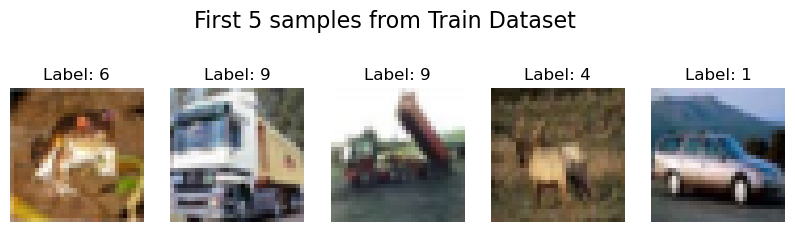

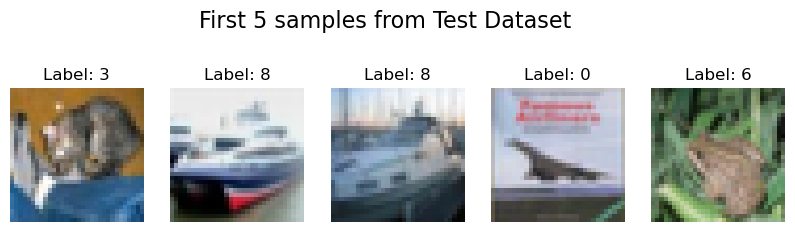

In [28]:

# Function to display the first 5 samples from a dataset
def display_samples(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    fig.suptitle(title, fontsize=16)
    
    for i in range(5):
        image, label = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))  
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.show()

# Display the first 5 samples from the train dataset
display_samples(trainset, "First 5 samples from Train Dataset")

# Display the first 5 samples from the test dataset
display_samples(testset, "First 5 samples from Test Dataset")

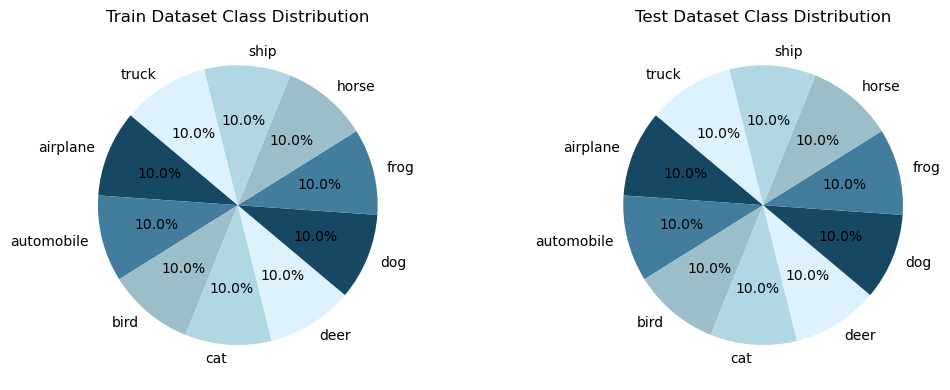

In [34]:
def count_labels(dataset):
    # Get the labels for the dataset as numpy array
    labels = dataset.targets

    # Count the occurrences of each label in the dataset
    label_counts = [0] * 10
    for label in labels:
        label_counts[label] += 1 
    
    return label_counts

# Count labels for train and test datasets
train_label_counts = count_labels(trainset)
test_label_counts = count_labels(testset)

# Class names for CIFAR-10 dataset
classes = train_labels

# Colors for the plots
colors = ['#164863', '#427d9d', '#9bbec8', '#b1d7e2', '#ddf2fd', '#164863', '#427d9d', '#9bbec8', '#b1d7e2', '#ddf2fd']

# Plot the distribution side by side as pie plots
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Plot for train dataset
axes[0].pie(train_label_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title('Train Dataset Class Distribution')

# Plot for test dataset
axes[1].pie(test_label_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors)
axes[1].set_title('Test Dataset Class Distribution')

plt.tight_layout()
plt.show()

# Building a model

### Model1

In [69]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the dataloaders for training and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define the CNN class
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.fc3 = nn.Linear(in_features=60, out_features=40)
        self.out = nn.Linear(in_features=40, out_features=10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = x.view(-1, 12 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

# Initialize the model
model = CNNNetwork()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and validate the model
num_epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}')

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(test_loader)
    val_losses.append(epoch_val_loss)
    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Files already downloaded and verified
Files already downloaded and verified
Epoch [10/50], Train Loss: 1.4393, Train Accuracy: 0.4748
Epoch [10/50], Validation Loss: 1.4166, Validation Accuracy: 0.4829
Epoch [20/50], Train Loss: 1.1393, Train Accuracy: 0.5929
Epoch [20/50], Validation Loss: 1.1689, Validation Accuracy: 0.5792
Epoch [30/50], Train Loss: 0.9743, Train Accuracy: 0.6541
Epoch [30/50], Validation Loss: 1.0889, Validation Accuracy: 0.6243
Epoch [40/50], Train Loss: 0.8566, Train Accuracy: 0.6955
Epoch [40/50], Validation Loss: 1.0602, Validation Accuracy: 0.6319
Epoch [50/50], Train Loss: 0.7537, Train Accuracy: 0.7312
Epoch [50/50], Validation Loss: 1.0847, Validation Accuracy: 0.6373


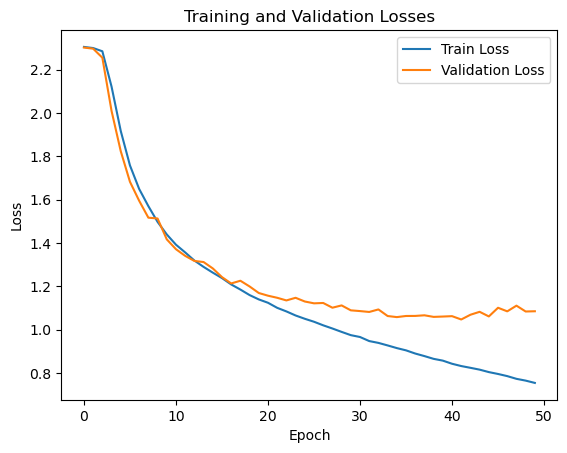

In [70]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### Model 2 - with dropout and early stopping

In [74]:
# Define the CNN class with dropout
class CNNNetworkWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.fc3 = nn.Linear(in_features=60, out_features=40)
        self.out = nn.Linear(in_features=40, out_features=10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = x.view(-1, 12 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

# Initialize the model
model = CNNNetworkWithDropout()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Implement early stopping
early_stopping = 10  # Stop if validation loss doesn't decrease for 10 consecutive epochs
no_improvement_count = 0
best_val_loss = float('inf')

# Train and validate the model
num_epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(test_loader)
    val_losses.append(epoch_val_loss)
    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping:
        print(f'Early stopping after {early_stopping} epochs of no improvement.')
        break

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch [1/50], Train Loss: 2.3042, Train Accuracy: 0.0994, Validation Loss: 2.3022, Validation Accuracy: 0.0973
Epoch [2/50], Train Loss: 2.3012, Train Accuracy: 0.1048, Validation Loss: 2.2989, Validation Accuracy: 0.1426
Epoch [3/50], Train Loss: 2.2917, Train Accuracy: 0.1305, Validation Loss: 2.2664, Validation Accuracy: 0.1438
Epoch [4/50], Train Loss: 2.1874, Train Accuracy: 0.1772, Validation Loss: 2.1031, Validation Accuracy: 0.2033
Epoch [5/50], Train Loss: 2.0716, Train Accuracy: 0.1997, Validation Loss: 1.9979, Validation Accuracy: 0.2291
Epoch [6/50], Train Loss: 1.9829, Train Accuracy: 0.2173, Validation Loss: 1.9080, Validation Accuracy: 0.2502
Epoch [7/50], Train Loss: 1.9179, Train Accuracy: 0.2422, Validation Loss: 1.8545, Validation Accuracy: 0.3026
Epoch [8/50], Train Loss: 1.8729, Train Accuracy: 0.2749, Validation Loss: 1.8048, Validation Accuracy: 0.3188
Epoch [9/50], Train Loss: 1.8251, Train Accuracy: 0.2983, Validation Loss: 1.7564, Validation Accuracy: 0.3408
E

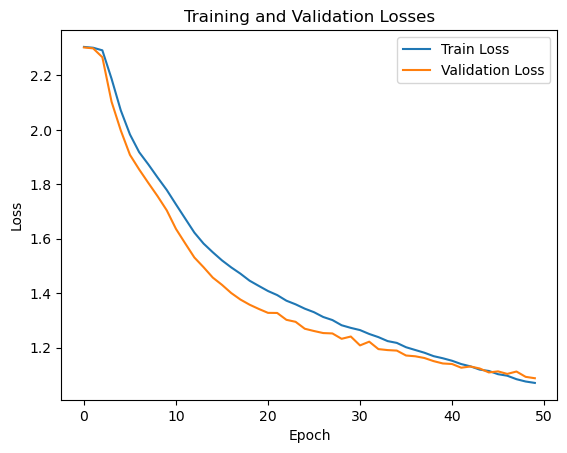

In [75]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### Model 3

#### I can see that the dropout and early stopping helped to prevent the overfitting but the accuracy is still not good enough (underfitting).                            I will try to build a more complex network

In [5]:
# Define the CNN class with batch normalization, dropout, and deeper network
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = CNNNetwork()

# Define the loss function and optimizer (using stochastic gradient descent)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Using SGD with momentum

# Implement early stopping
early_stopping = 10  # Stop if validation loss doesn't decrease for 10 consecutive epochs
no_improvement_count = 0
best_val_loss = float('inf')

# Train and validate the model
num_epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(test_loader)
    val_losses.append(epoch_val_loss)
    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping:
        print(f'Early stopping after {early_stopping} epochs of no improvement.')
        break

    # Print accuracy for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch [10/100], Train Loss: 0.9651, Train Accuracy: 0.6571, Validation Loss: 0.9024, Validation Accuracy: 0.6784
Epoch [20/100], Train Loss: 0.7681, Train Accuracy: 0.7290, Validation Loss: 0.7421, Validation Accuracy: 0.7404
Epoch [30/100], Train Loss: 0.6483, Train Accuracy: 0.7718, Validation Loss: 0.6492, Validation Accuracy: 0.7745
Epoch [40/100], Train Loss: 0.5531, Train Accuracy: 0.8051, Validation Loss: 0.6155, Validation Accuracy: 0.7874
Epoch [50/100], Train Loss: 0.4845, Train Accuracy: 0.8278, Validation Loss: 0.5697, Validation Accuracy: 0.8048
Epoch [60/100], Train Loss: 0.4241, Train Accuracy: 0.8499, Validation Loss: 0.5533, Validation Accuracy: 0.8142
Epoch [70/100], Train Loss: 0.3795, Train Accuracy: 0.8643, Validation Loss: 0.5495, Validation Accuracy: 0.8194
Epoch [80/100], Train Loss: 0.3315, Train Accuracy: 0.8824, Validation Loss: 0.5463, Validation Accuracy: 0.8184
Epoch [90/100], Train Loss: 0.2952, Train Accuracy: 0.8953, Validation Loss: 0.5784, Validation 

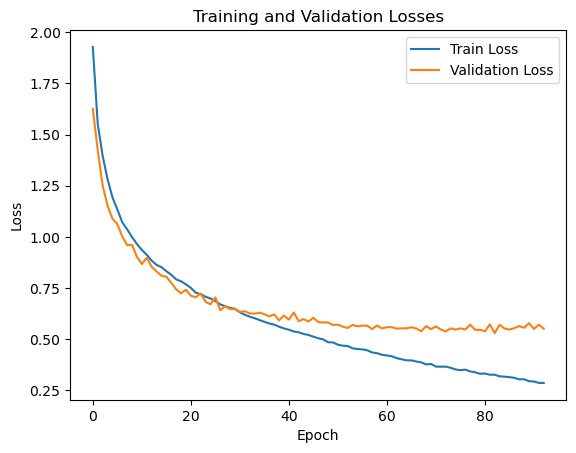

In [6]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### Model 4

#### The accuracy is higher now, but I have overfitting. I will try higher p (dropout rate)

In [3]:
# Define the CNN class with batch normalization, dropout, and deeper network
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = CNNNetwork()

# Define the loss function and optimizer (using stochastic gradient descent)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Using SGD with momentum

# Implement early stopping
early_stopping = 10  # Stop if validation loss doesn't decrease for 10 consecutive epochs
no_improvement_count = 0
best_val_loss = float('inf')

# Train and validate the model
num_epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(test_loader)
    val_losses.append(epoch_val_loss)
    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping:
        print(f'Early stopping after {early_stopping} epochs of no improvement.')
        break

    # Print accuracy for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch [10/100], Train Loss: 1.1661, Train Accuracy: 0.5824, Validation Loss: 1.1173, Validation Accuracy: 0.5942
Epoch [20/100], Train Loss: 0.9397, Train Accuracy: 0.6695, Validation Loss: 0.8516, Validation Accuracy: 0.6986
Epoch [30/100], Train Loss: 0.8237, Train Accuracy: 0.7132, Validation Loss: 0.7466, Validation Accuracy: 0.7401
Epoch [40/100], Train Loss: 0.7396, Train Accuracy: 0.7415, Validation Loss: 0.6884, Validation Accuracy: 0.7625
Epoch [50/100], Train Loss: 0.6816, Train Accuracy: 0.7620, Validation Loss: 0.6423, Validation Accuracy: 0.7776
Epoch [60/100], Train Loss: 0.6338, Train Accuracy: 0.7800, Validation Loss: 0.6447, Validation Accuracy: 0.7794
Epoch [70/100], Train Loss: 0.5880, Train Accuracy: 0.7936, Validation Loss: 0.6209, Validation Accuracy: 0.7866
Epoch [80/100], Train Loss: 0.5480, Train Accuracy: 0.8080, Validation Loss: 0.5912, Validation Accuracy: 0.8001
Epoch [90/100], Train Loss: 0.5157, Train Accuracy: 0.8187, Validation Loss: 0.5751, Validation 

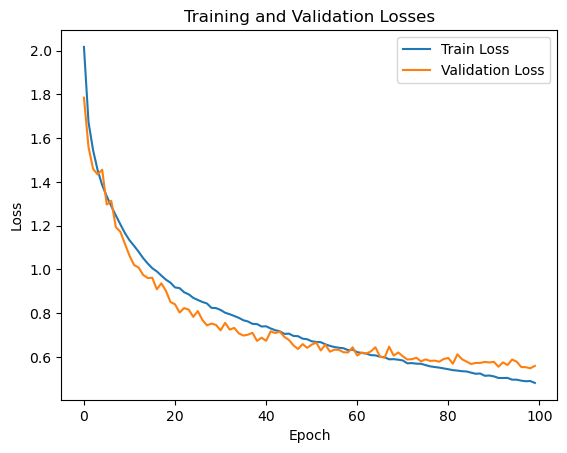

In [4]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### model 5

#### The accuracy is higher now, but I want to try to change the optimization method because the validation graph is noisy

In [13]:
# Define the CNN class with batch normalization, dropout, and deeper network
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = CNNNetwork()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Implement early stopping
early_stopping = 10  # Stop if validation loss doesn't decrease for 20 consecutive epochs
no_improvement_count = 0
best_val_loss = float('inf')

# Train and validate the model
num_epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(test_loader)
    val_losses.append(epoch_val_loss)
    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping:
        print(f'Early stopping after {early_stopping} epochs of no improvement.')
        break

    # Print accuracy for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch [10/100], Train Loss: 0.8325, Train Accuracy: 0.7126, Validation Loss: 0.7262, Validation Accuracy: 0.7500
Epoch [20/100], Train Loss: 0.6953, Train Accuracy: 0.7599, Validation Loss: 0.6189, Validation Accuracy: 0.7905
Epoch [30/100], Train Loss: 0.6340, Train Accuracy: 0.7820, Validation Loss: 0.5894, Validation Accuracy: 0.7980
Epoch [40/100], Train Loss: 0.5793, Train Accuracy: 0.7988, Validation Loss: 0.5667, Validation Accuracy: 0.8094
Epoch [50/100], Train Loss: 0.5549, Train Accuracy: 0.8099, Validation Loss: 0.5590, Validation Accuracy: 0.8131
Early stopping after 10 epochs of no improvement.


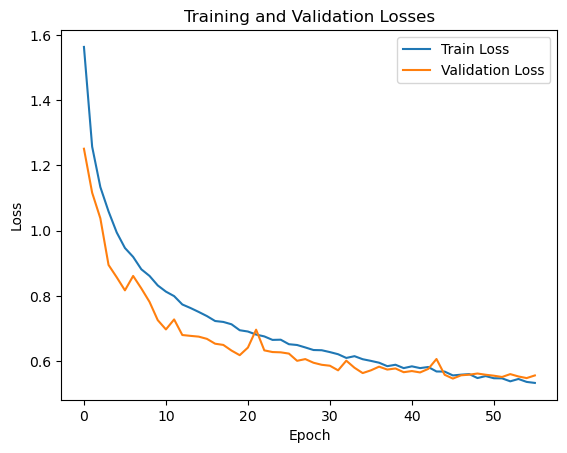

In [14]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluate the model on the test set
I chose model 5

In [3]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = CNNNetwork()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Implement early stopping
early_stopping = 10  # Stop if validation loss doesn't decrease for 20 consecutive epochs
no_improvement_count = 0
best_val_loss = float('inf')

# Train the model
num_epochs = 100
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # Test loop
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_loss = test_running_loss / len(test_loader)
    test_losses.append(epoch_test_loss)
    test_acc = correct_test / total_test
    test_accs.append(test_acc)

    # Early stopping check
    if epoch_test_loss < best_val_loss:
        best_val_loss = epoch_test_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping:
        print(f'Early stopping after {early_stopping} epochs of no improvement.')
        break

    # Print accuracy for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch [10/100], Train Loss: 0.8360, Train Accuracy: 0.7111, Test Loss: 0.8022, Test Accuracy: 0.7214
Epoch [20/100], Train Loss: 0.6878, Train Accuracy: 0.7611, Test Loss: 0.6589, Test Accuracy: 0.7777
Epoch [30/100], Train Loss: 0.6191, Train Accuracy: 0.7871, Test Loss: 0.6257, Test Accuracy: 0.7873
Epoch [40/100], Train Loss: 0.5710, Train Accuracy: 0.8022, Test Loss: 0.6267, Test Accuracy: 0.7885
Epoch [50/100], Train Loss: 0.5260, Train Accuracy: 0.8173, Test Loss: 0.5761, Test Accuracy: 0.8068
Early stopping after 10 epochs of no improvement.


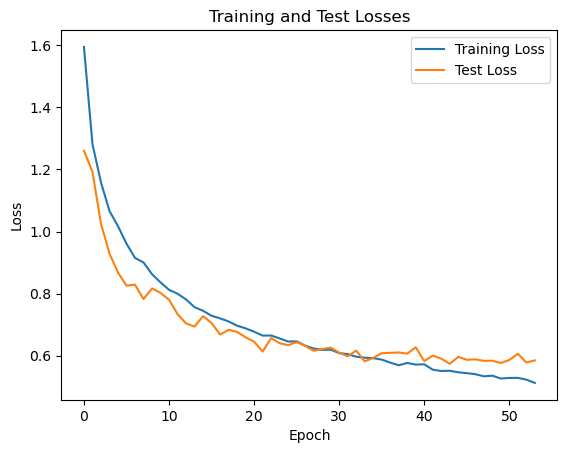

In [4]:
# Plot the training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

#### I will try to reduce the n to prevent the overfitting 

In [8]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = CNNNetwork()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Implement early stopping
early_stopping = 5  # Stop if validation loss doesn't decrease for 20 consecutive epochs
no_improvement_count = 0
best_val_loss = float('inf')

# Train the model
num_epochs = 100
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # Test loop
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_loss = test_running_loss / len(test_loader)
    test_losses.append(epoch_test_loss)
    test_acc = correct_test / total_test
    test_accs.append(test_acc)

    # Early stopping check
    if epoch_test_loss < best_val_loss:
        best_val_loss = epoch_test_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping:
        print(f'Early stopping after {early_stopping} epochs of no improvement.')
        break

    # Print accuracy for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch [10/100], Train Loss: 0.7970, Train Accuracy: 0.7247, Test Loss: 0.6998, Test Accuracy: 0.7535
Epoch [20/100], Train Loss: 0.6651, Train Accuracy: 0.7720, Test Loss: 0.6259, Test Accuracy: 0.7834
Epoch [30/100], Train Loss: 0.6013, Train Accuracy: 0.7947, Test Loss: 0.5630, Test Accuracy: 0.8065
Early stopping after 5 epochs of no improvement.


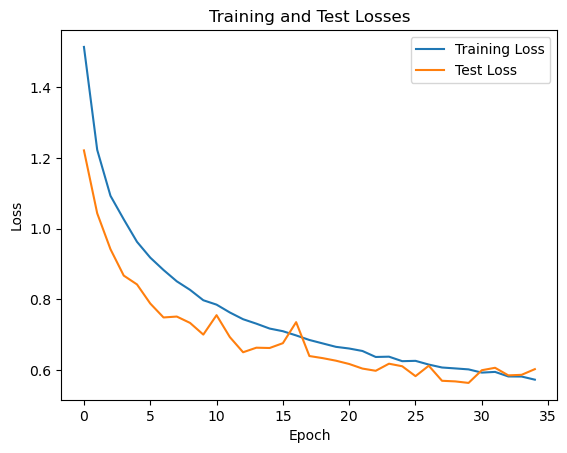

In [9]:
# Plot the training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

#### n=5 is better cause now the overfitting is not so bad as in model 5

###  I arrived at a model that satisfies me in terms of performance and I was also able to prevent the overfitting that was there